In [2]:
import lightkurve as lk

kic_id = 'KIC10011070'
flare_time = 415.62

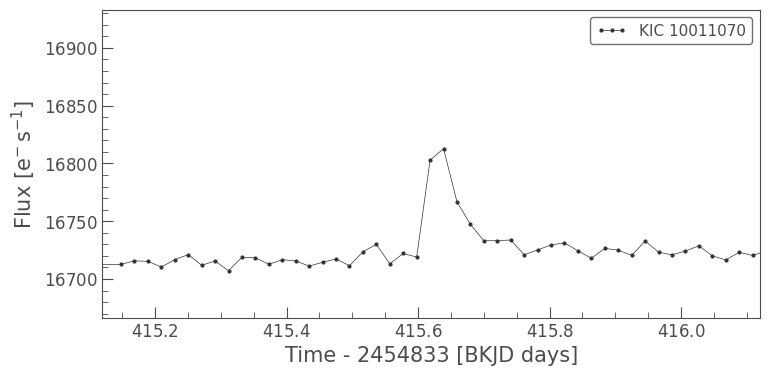

In [3]:
%matplotlib inline
lc = lk.search_lightcurve(kic_id, author="Kepler", cadence="long", quarter=4).download()
lc.plot(marker='o').set_xlim(flare_time-0.5, flare_time+0.5);

In [4]:
tpf = lk.search_targetpixelfile(kic_id, author="Kepler", cadence="long", quarter=4).download()

In [5]:
from src.flare_localization import FlareLocalization
flare = FlareLocalization(flare_time=flare_time, tpf=tpf)
flare.compute_flare_image()

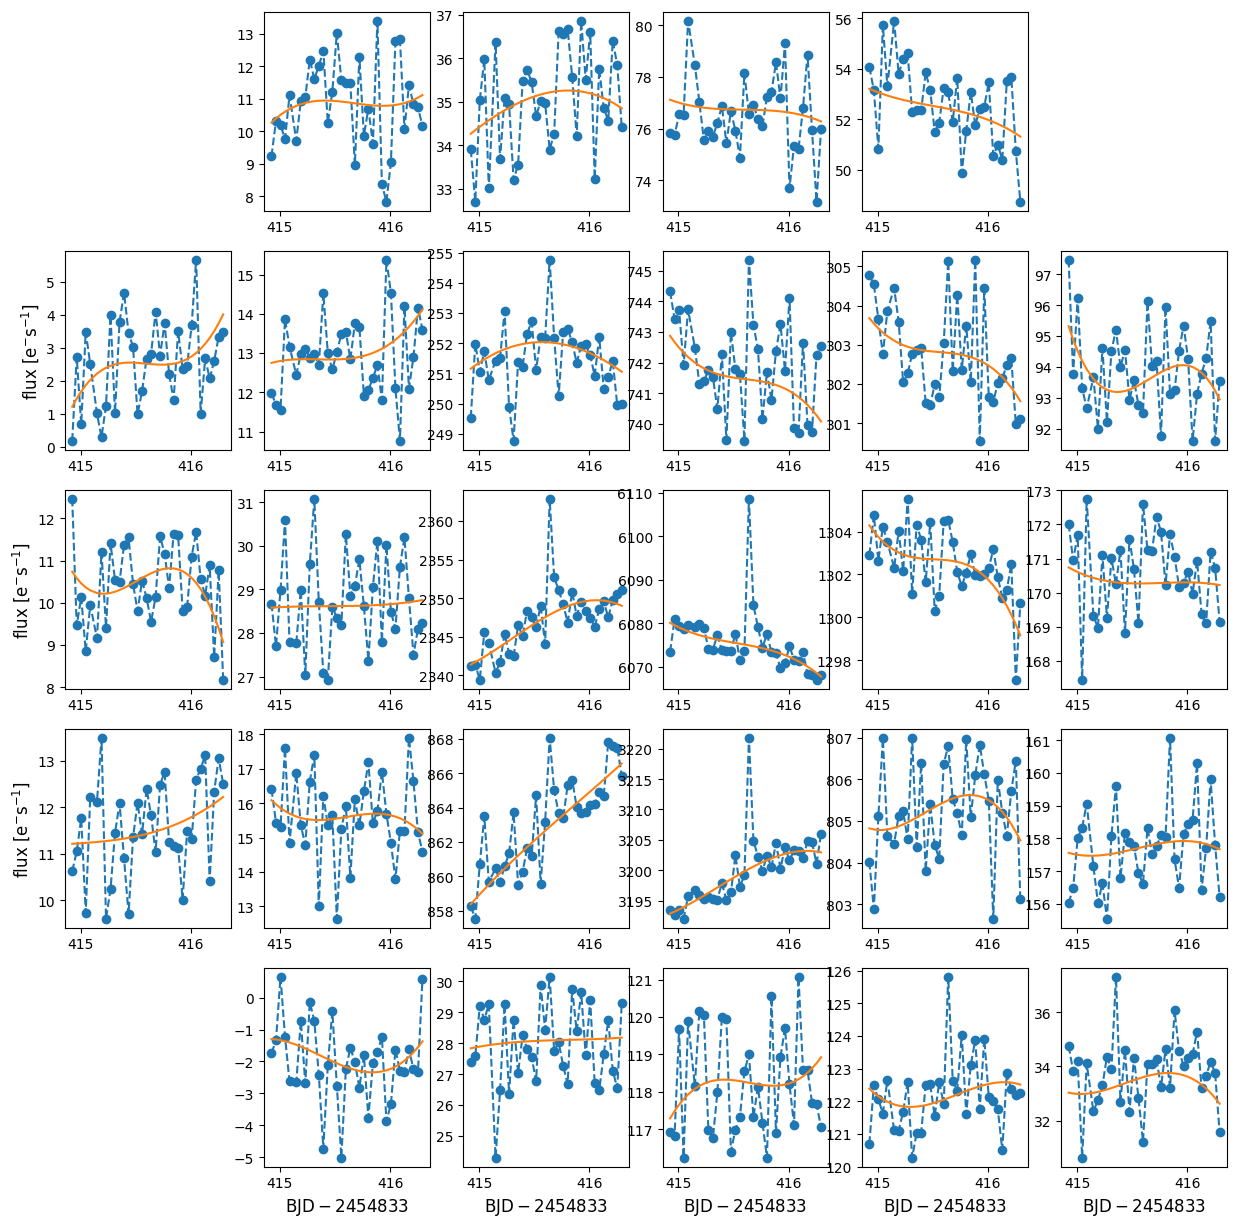

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plotDetrendingPixelFLuxes(time: np.ndarray, flux: np.ndarray, mean_flux: np.ndarray) -> None:
    n_xpix = flux.shape[1]
    n_ypix = flux.shape[2]
    plt.figure(figsize=(15,15))
    c=1
    for i in range(n_xpix):
            i= n_xpix - 1 - i
            for j in range(n_ypix):
                if not(np.isnan(flux[0, i, j])):
                    plt.subplot(n_xpix, n_ypix, c)
                    plt.plot(time, flux[:, i, j], "o--")
                    plt.plot(time, mean_flux[:, i, j], "-")
                    if j == 0:
                        plt.ylabel(r"$\mathrm{flux}$ $[\mathrm{e}^{-} \mathrm{s}^{-1}]$", fontsize=12)
                    if i ==0:
                        plt.xlabel( r"$\mathrm{BJD  -  2454833}$" , fontsize=12)
                c = c + 1
    plt.show()

plotDetrendingPixelFLuxes(time=flare.flare_image.time_within_window_with_flare,
                          flux=flare.flare_image.tpfs_within_window_with_flare,
                          mean_flux=flare.flare_image.quiet_stellar_fluxes_within_window_with_flare)



In [8]:
flare.localize_flare()

flare col : 201.0339956532782 - 0.07786460587678334 + 0.08293677113479703
flare row : 88.79510660395187 - 0.08219560735820153 + 0.08027026652631264
flare flux : 75.2083528279644 - 9.610993548190692 + 10.586814164040902
offset flux $[e^{-1}s^{-1}]$ : 1.6622251083465884 - 0.29787629505146684 + 0.3288456456532196


In [15]:
flare.get_gaia_data()
print(flare.gaia_data)

       _r               Source     RA_ICRS    DE_ICRS     Gmag   pmRA  e_pmRA  \
0   0.136  2129091399748178816  291.544364  46.980123  14.9028 -4.227   0.049   
1   6.906  2129091399743340288  291.544153  46.982046  20.5577 -0.435   1.674   
2   5.292  2129091399743336192  291.543038  46.981266  20.4331 -0.751   1.316   
3  12.971  2129091395448651392  291.549029  46.978382  20.2612  2.653   1.119   

    pmDE  e_pmDE  pmRApmDEcor     Plx   e_Plx  PlxpmRAcor  PlxpmDEcor  
0 -6.384   0.048      -0.0784  1.3634  0.0234      0.1053     -0.0771  
1 -0.529   1.842      -0.1716 -0.7332  0.7420      0.1637      0.0547  
2  0.768   1.715      -0.2252 -0.0427  0.5950      0.2608     -0.1125  
3 -3.976   1.187      -0.0773  0.8873  0.5294      0.3031     -0.0468  


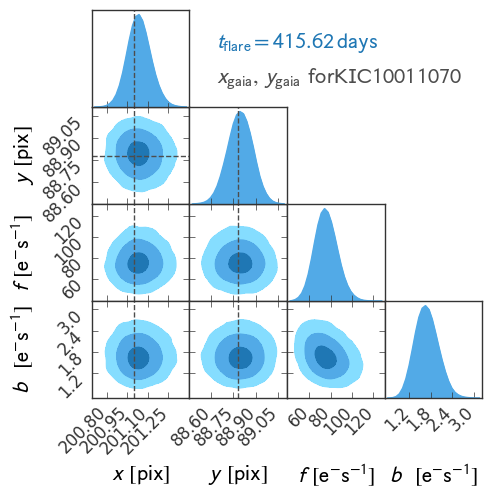

In [16]:
import pygtc

labels = [r"$x$ $[\mathrm{pix}]$", r"$y$ $[\mathrm{pix}]$",
               r"$f$ $[\mathrm{e}^{-}\mathrm{s}^{-1}]$",
               r"$b$  $[\mathrm{e}^{-}\mathrm{s}^{-1}]$"]

GTC = pygtc.plotGTC(chains=[flare.mcmc.chain],
                    paramNames=labels,
                    plotName=None, \
                    chainLabels=["$t_\mathrm{flare}=415.62\, \mathrm{days}$"], \
    	            truths=((flare.star_positions[0, 0], flare.star_positions[0, 1], None, None)),
                    nContourLevels = 3,
                    sigmaContourLevels=True,
                    truthLabels=[r"$x_\mathrm{gaia}, \,y_\mathrm{gaia}$ $\mathrm{ for "+kic_id+"}$"],   figureSize='MNRAS_page' ,
                    customLabelFont = {'family':'sans-serif', 'size':16},
                    customLegendFont = {'family':'sans-serif', 'size':16}, customTickFont =  {'family':'sans-serif', 'size':12})

In [6]:
#########################################
from matplotlib.patches import Ellipse
import matplotlib.cm as cm



def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

def generateEllipse(x,y,persentage):
    cov = np.cov(x, y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    if persentage ==0.68:
        nstd = np.sqrt(2.27887)
    if persentage ==0.95:
        nstd = np.sqrt(5.99146)
    if persentage ==0.999:
        print("THis is the case 99:")
        nstd = np.sqrt(13.81551)

    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
          width=w, height=h,
          angle=theta, color='red')
    print(" w, h = 2 * nstd * np.sqrt(vals):", w, h)
    ell_center_coords = (np.mean(x), np.mean(y))
    ell_width_height = (w, h)
    return ell, ell_center_coords, ell_width_height, theta

##############################

def plot_residual_flare_with_mcmcm(d_1, ax, extend, ra_dec_pix_2015, data_gaia):
    data_to_plot = d_1["residual_flare_flux"]
    data_to_plot = data_to_plot+abs(np.min(data_to_plot[~np.isnan(data_to_plot)]))
    im = ax.imshow(  data_to_plot, origin ="lower", extent = extend,  vmin=0,vmax=38 )
    ax.plot( d_1["chain"][:,0], d_1["chain"][:,1] , "b.", alpha=0.3)
    ax.set_xlabel("$\mathrm{Pixel \, Column \, Number}$", fontsize=18)
    sccatter = ax.scatter( ra_dec_pix_2015[:, 0], ra_dec_pix_2015[:,1],  c=data_gaia.Gmag, \
            s=75, marker="*", cmap=cm.cool, label = "J2015.5", zorder=100000000000)

    ell, ell_center_coords, ell_width_height, theta = generateEllipse(d_1["chain"][:, 0], d_1["chain"][:, 1], 0.68)
    ell.set_facecolor('none')
    ell.set_zorder(12100000)
    ax.add_artist(ell)

    ell, ell_center_coords, ell_width_height, theta = generateEllipse(d_1["chain"][:, 0], d_1["chain"][:, 1], 0.95)
    ell.set_facecolor('none')
    ell.set_zorder(12100000)
    ax.add_artist(ell)

    ell, ell_center_coords, ell_width_height, theta = generateEllipse(d_1["chain"][:, 0], d_1["chain"][:, 1], 0.999)
    ell.set_facecolor('none')
    ell.set_zorder(12100000)
    ax.add_artist(ell)
    return im, sccatter



fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5,9))
extend = [lp.column-0.5, lp.column + residual_flare_flux.shape[2]-0.5, lp.row-0.5, lp.row + residual_flare_flux.shape[1]-0.5]
ax = axes.flat[0]
plot_apperture_mask(ax, lp)
im, sccatter = plot_residual_flare_with_mcmcm(d_1, ax, extend, ra_dec_pix_2015, data_gaia)
ax.set_ylabel("$\mathrm{Pixel \,  Row \, Number}$", fontsize=18)
ax.set_title("$t_\mathrm{flare}=415.62$ $\mathrm{days}$", fontsize=16)
cbar_ax = fig.add_axes([0.82, 0.53, 0.025, 0.35])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r"$\mathrm{residual \, flux}$ $[\mathrm{e}^{-} \mathrm{s}^{-1}]$", fontsize=16)

